In [1]:
import numpy as np
from numpy import pi
import pyregion
import graphinglib as gl
from uncertainties import ufloat, umath
from scipy.stats import norm
import gvar
# import latexify   # only for python <= 3.11

from src.hdu.maps.map import Map

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/fits.py:640: SyntaxWarning: invalid escape sequence '\s'
  part1 = f"{self.amplitude:.3f} \sin({self.frequency_rad:.3f}x"
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/fits.py:896: SyntaxWarning: invalid escape sequence '\e'
  part1 = f"{self.parameters[0]:.3f} \exp({self.parameters[1]:.3f}x"
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/fits.py:985: SyntaxWarning: invalid escape sequence '\m'
  """
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/fits.py:1040: SyntaxWarning: invalid escape sequence '\m'
  """
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/graphinglib/fits.py:1109: SyntaxWarning: invalid escape sequence '\m'
  return f"$\mu = {self.mean:.3f}, \sigma = {self.standard_deviation:.3f}, A = {self.amplitude:.3f}$"
/Libr

In [2]:
# @latexify.function(use_math_symbols=True)
def pdf(x, sigma, mu):
    return 1 / (np.sqrt(2*pi) * sigma) * np.exp((-(x - mu)**2) / (2*sigma**2))

# pdf

$$ \displaystyle \mathrm{pdf}(x, \sigma, \mu) = \frac{1}{\sqrt{ 2 \pi } \cdot \sigma} \cdot \exp \mathopen{}\left( \frac{-\mathopen{}\left( x - \mu \mathclose{}\right)^{2}}{2 \sigma^{2}} \mathclose{}\right) $$

# Computations of PDF histograms

In [19]:
regions = [
    None,
    pyregion.open("summer_2023/gaussian_fitting/regions/region_1.reg"),
    pyregion.open("summer_2023/gaussian_fitting/regions/region_2.reg"),
    pyregion.open("summer_2023/gaussian_fitting/regions/region_3.reg")
]

def make_pdf_histograms(map_: Map) -> list[gl.Histogram]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = np.log(masked.data / np.nanmedian(masked.data))
        # data = masked.data
        stats = masked.data.get_statistics()
        # probability_density = pdf(
        #     x=np.log(masked.data / stats["median"]),
        #     sigma=stats["stddev"],
        #     mu=stats["median"]
        # )
        probability_density = pdf(
            x=data,
            sigma=np.nanstd(data),
            mu=np.nanmedian(data)
        )

        flat = (masked.data/np.nanmedian(masked.data)).flatten()

        bin_width = 2 * masked.uncertainties.get_statistics()["median"]/masked.data.get_statistics()["median"]
        plottables.append(gl.Scatter(
            flat,
            norm.pdf(flat, loc=np.nanmedian(flat), scale=np.nanstd(flat))
        ))
        # plottables.append(gl.Histogram(
        #     data=norm.pdf(flat[~np.isnan(flat)], loc=np.nanmedian(flat), scale=np.nanstd(flat)),
        #     # data=norm.pdf(data[~np.isnan(data)]),
        #     # data=probability_density[~np.isnan(probability_density)],
        #     face_color="black",
        #     edge_color="none",
        #     alpha=1,
        #     normalize=False,
        #     number_of_bins=20,
        #     show_params=False,
        #     # number_of_bins=int(((np.nanmax(probability_density) + bin_width - np.nanmin(probability_density)) 
        #                         # / bin_width))
        #     # number_of_bins=(map_.uncertainties.get_statistics()["median"] / stats["stddev"])
        # ))

    return plottables

def make_simple_histograms(map_: Map) -> list[gl.Histogram]:
    """
    Make a simple count histogram
    """
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        bin_width = 1
        plottables.append(gl.Histogram(
            data=masked.data[~np.isnan(masked.data)],
            face_color="black",
            edge_color="none",
            alpha=1,
            normalize=False,
            # number_of_bins=20,
            number_of_bins=int(((np.nanmax(masked.data) + bin_width - np.nanmin(masked.data)) / bin_width)),
            show_params=False
        ))

    return plottables

def make_pdf_scatters(map_: Map, normalize: bool=False, fit: bool=False) -> list[gl.Scatter]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = (masked.data/np.nanmedian(masked.data)).flatten()
        data = np.sort(data[~np.isnan(data)])
        if normalize: 
            data = np.log(data)
        
        current_plots = [
            gl.Scatter(
                data,
                pdf(data, np.nanstd(data), np.nanmedian(data)),
                # norm.pdf(data, loc=np.nanmedian(data), scale=np.nanstd(data)),
            )
        ]
        if fit:

            current_plots.append(gl.FitFromGaussian(
                current_plots[0]
            ))

        plottables.append(current_plots)

    return plottables

def make_fit_histogram(map_: Map, normalize: bool=False) -> list[gl.Histogram, gl.Curve]:
    plottables = []
    for region in regions:
        masked = map_.get_masked_region(region)
        data = masked.data.flatten()
        data = np.sort(data[~np.isnan(data)])
        bin_width = np.nanmedian(masked.uncertainties)
        if normalize: 
            data = np.log(data/np.nanmedian(data))
            bin_width = umath.log(ufloat(np.nanmedian(masked.data), np.nanmedian(masked.uncertainties))
                             / ufloat(np.nanmedian(masked.data), np.nanmedian(masked.uncertainties))).std_dev
        
        # Create the array of bins, considering that the upper bound is cropped lower to match the bin width
        bins = np.arange(np.nanmin(data), np.nanmax(data) + bin_width*0.99, bin_width)
        hist = np.histogram(data, bins=bins)[0]
        
        current_plots = [
            gl.Histogram(
                data=data,
                face_color="black",
                edge_color="none",
                alpha=1,
                normalize=False,
                number_of_bins=bins,
                show_params=False
            ),
            gl.Scatter(
                (bins + bin_width/2)[:-1],
                hist,
            ),
        ]
        current_plots.append(
            gl.FitFromGaussian(
                curve_to_be_fit=current_plots[1],
                color="blue",
                guesses=[
                    np.max(current_plots[1].y_data),
                    current_plots[1].x_data[np.argmax(current_plots[1].y_data)],
                    np.std(current_plots[1].y_data) * np.diff(current_plots[1].x_data)[0],
                ]
            )
        )
        if np.max(current_plots[1].y_data) == 50:
            print(current_plots[1].x_data[np.argmax(current_plots[1].y_data)])
            print(np.std(current_plots[1].y_data))
            print(np.max(current_plots[1].y_data))

        max_x = current_plots[1].x_data[np.argmax(hist)]
        fit = gl.FitFromFunction(
            function=lambda x, A, mu, sigma: A/x * np.exp(-(np.log(x) - mu)**2 / (2*sigma**2)),
            curve_to_be_fit=current_plots[1],
            guesses=[
                np.max(hist)*max_x,
                np.log(max_x),
                0.5
            ],
            color="red",
        )
        fit.label = \
            f"$\mu={fit.parameters[1]:.3f}$, $\sigma={fit.parameters[2]:.3f}$, $A={fit.parameters[0]:.3f}$"
        current_plots.append(fit)
        # np.savetxt("t.txt", np.stack((current_plots[1].x_data, current_plots[1].y_data), axis=1))
        # raise

        plottables.append(current_plots)

    return plottables

<>:156: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\s'
<>:156: SyntaxWarning: invalid escape sequence '\m'
<>:156: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z8/44crt9313mlc559ypygm9ptw0000gn/T/ipykernel_35571/1180383026.py:156: SyntaxWarning: invalid escape sequence '\m'
  f"$\mu={fit.parameters[1]:.3f}$, $\sigma={fit.parameters[2]:.3f}$, $A={fit.parameters[0]:.3f}$"
/var/folders/z8/44crt9313mlc559ypygm9ptw0000gn/T/ipykernel_35571/1180383026.py:156: SyntaxWarning: invalid escape sequence '\s'
  f"$\mu={fit.parameters[1]:.3f}$, $\sigma={fit.parameters[2]:.3f}$, $A={fit.parameters[0]:.3f}$"


In [20]:
names = [
    "main region",
    "diffuse region",
    "central region",
    "filament region"
]

turbulence_map = Map.load("summer_2023/gaussian_fitting/maps/computed_data_selective/turbulence.fits")
density_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                 +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                          +"dens_it_sii_sans_fcorr_nii_plus_pluserr_pouss_seuil_errt_1000.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/"
                   +"dens_it_sii_sans_fcorr_nii_plus_plusmin_pouss_seuil_errt_1000.fits").header
)
temperature_map = Map(
    data=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").data,
    uncertainties=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_err_8300.fits").data,
    header=Map.load("summer_2023/gaussian_fitting/maps/external_maps/temp_it_nii_8300.fits").header
)

alignment_map = (turbulence_map * 0).get_reprojection_on(density_map)

# Remove pixels that are not present in the alignment map
density_map += alignment_map
temperature_map += alignment_map

figs = []
for name, plottable in zip(names, make_fit_histogram(density_map, normalize=False)):
    fig = gl.Figure(
        x_label="Density [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
multifig.save("summer_2023/gaussian_fitting/figures/density/hist_fit_lognormal.pdf")

figs = []
for name, plottable in zip(names, make_fit_histogram(turbulence_map, normalize=False)):
    fig = gl.Figure(
        x_label="Turbulence [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
multifig.save("summer_2023/gaussian_fitting/figures/turbulence/hist_fit_lognormal.pdf")

figs = []
for name, plottable in zip(names, make_fit_histogram(temperature_map, normalize=False)):
    fig = gl.Figure(
        x_label="Temperature [-]",
        y_label=f"PDF in {name}"
    )
    fig.add_elements(*plottable)
    figs.append(fig)
multifig = gl.MultiFigure.from_grid(figs, (2, 2), size=(10,10))
multifig.save("summer_2023/gaussian_fitting/figures/temperature/hist_fit_lognormal.pdf")

585.4730982258609
15.523671440738495
50


# Tests

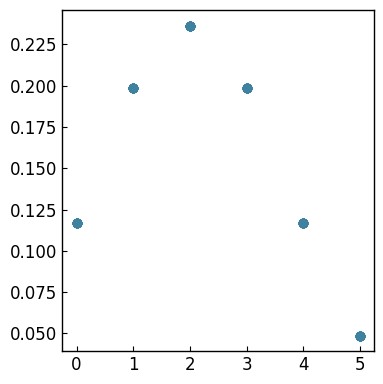

In [5]:
fig = gl.Figure(size=(4,4))

# rand = np.random.normal(5, 1, 100000)
# x = np.linspace(-5, 5, num=100)
# x = np.random.uniform(1,11,100)
x = np.random.choice(6, 100)
# s = np.log(rand/np.nanmedian(rand))


# fig.add_elements(gl.Histogram(
#     # data=s,
#     # data=norm.pdf(np.log(rand/np.nanmedian(rand))),
#     # data=norm.pdf(s),
#     data=norm.pdf(x, loc=0, scale=1),
#     face_color="black",
#     edge_color="none",
#     alpha=1,
#     normalize=False,
#     number_of_bins=25,
#     # number_of_bins=int(((np.nanmax(masked.data) + bin_width - np.nanmin(masked.data)) / bin_width)),
#     show_params=False
# ))

# fig.show()
# fig = gl.Figure(size=(4,4))
# s = np.log(x/np.nanmedian(x))
s = x
fig.add_elements(gl.Scatter(
    x_data=s,
    y_data=pdf(s, np.nanstd(s), np.nanmedian(s)),
))

fig.show()

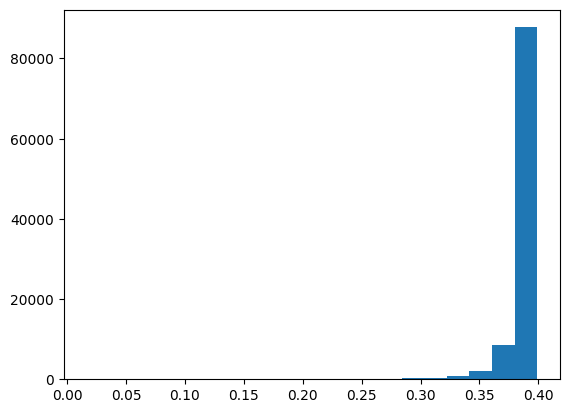

In [6]:
import matplotlib.pyplot as plt
rand = np.random.normal(5, 1, 100000)

plt.hist(
    x=norm.pdf(np.log(rand/np.nanmedian(rand))),
    bins=20,
)

plt.show()